In [52]:
using Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate();

  Activating project at `~/Desktop/Work/Research/LEGO-project/LEGO-3D_Dyn`


In [53]:
import ForwardDiff as FD
using LinearAlgebra
using Plots

include(joinpath(@__DIR__,"helpers/quaternions.jl"))

quat2rot (generic function with 1 method)

In [54]:
function newton_euler_dyn(
  ᴮstates::Vector, 
  ᴮforcing::Vector, 
  params_rb::NamedTuple)

  ᴮv, ᴮω, q = ᴮstates[4:6], ᴮstates[7:9], ᴮstates[10:13]
  ᴮF, ᴮτ = ᴮforcing[1:3], ᴮforcing[4:6]

  Q = quat2rot(q)
  m, J, g = params_rb.m, params_rb.J, params_rb.g
  ᴺg = [0, 0, -g]
  ᴮg = Q' * ᴺg

  ᴺṙ = Q * ᴮv
  q̇ = (1/2) * L(q) * H * ᴮω
  ᴮv̇ = (1/m) * ᴮF + ᴮg - hat(ᴮω) * ᴮv
  ᴮ̇ω = J  \ (ᴮτ - hat(ᴮω) * (J * ᴮω))

  return [ᴺṙ; ᴮv̇; ᴮ̇ω; q̇]
end

function back_euler_residual(
  states1::Vector, 
  states2::Vector, 
  forcing::Vector, 
  params_rb::NamedTuple, 
  dt::Float64)
  
  residual = states1 + dt * newton_euler_dyn(states2, forcing, params_rb) - states2
  return residual
end

function back_euler_dyn_step(
  states1::Vector, 
  forcing::Vector, 
  params_rb::NamedTuple, 
  dt::Float64; 
  max_iter=100, 
  tol=1e-6)

  states2 = states1 # initialize next_states guess with the current states
  for i in 1:max_iter
    residual = back_euler_residual(states1, states2, forcing, params_rb, dt)

    if norm(residual) < tol
      return states2
    end
    # newton root finding 
    jac = FD.jacobian(s2 -> back_euler_residual(states1, s2, forcing, params_rb, dt), states2)
    Δstates = -jac \ residual
    states2 += Δstates
  end
  throw("Implicit Euler dynamics integration did not converge")
end

back_euler_dyn_step (generic function with 1 method)

In [62]:
link1_params = (m=0.1, J=Diagonal([0.1, 1, 1]), g=0)

ᴺr = [0, 0, 0]
q = [1, 0, 0, 0]
ᴮv = [0, 0, 0]
ᴮω = [0, 0, 0]
states = [ᴺr; ᴮv; ᴮω; q]

ᴮF = [0, 0, 0]
ᴮτ = [0, 0, 1]
forcing = [ᴮF; ᴮτ]

h = 0.01 # 100 Hz
T_final = 5 # final time
T_hist = Array(0:h:T_final)
N = length(T_hist)

states_hist = zeros(13, N)
states_hist[:, 1] .= states

for i in 2:N
  states_hist[:, i] .= back_euler_dyn_step(states_hist[:, i-1], forcing, link1_params, h)
end

13×501 Matrix{Float64}:
 0.0  0.0     0.0      0.0     0.0     …   0.0         0.0         0.0
 0.0  0.0     0.0      0.0     0.0         0.0         0.0         0.0
 0.0  0.0     0.0      0.0     0.0         0.0         0.0         0.0
 0.0  0.0     0.0      0.0     0.0         0.0         0.0         0.0
 0.0  0.0     0.0      0.0     0.0         0.0         0.0         0.0
 0.0  0.0     0.0      0.0     0.0     …   0.0         0.0         0.0
 0.0  0.0     0.0      0.0     0.0         0.0         0.0         0.0
 0.0  0.0     0.0      0.0     0.0         0.0         0.0         0.0
 0.0  0.01    0.02     0.03    0.04        4.98        4.99        5.0
 1.0  1.0     1.0      1.0     1.0         0.947492    0.948589    0.949095
 0.0  0.0     0.0      0.0     0.0     …   0.0         0.0         0.0
 0.0  0.0     0.0      0.0     0.0         0.0         0.0         0.0
 0.0  5.0e-5  0.00015  0.0003  0.0005     -0.0676476  -0.0439803  -0.0202529

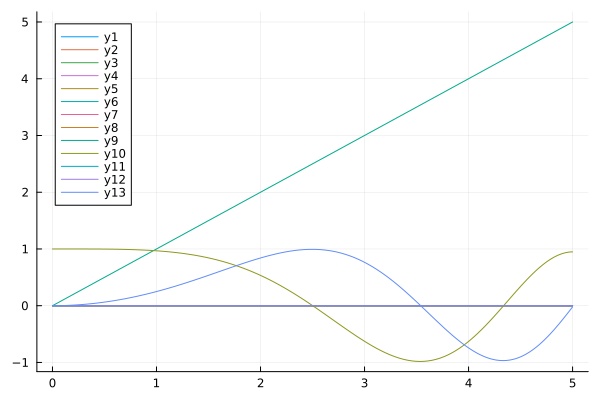

In [66]:
display(states_hist)
display(plot(T_hist, states_hist'))

In [44]:
using MeshCat, GeometryBasics, CoordinateTransformations, Rotations

In [50]:
vis = Visualizer()
render(vis)

┌ Info: Listening on: 127.0.0.1:8701, thread id: 1
└ @ HTTP.Servers /home/sman/.julia/packages/HTTP/sJD5V/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /home/sman/.julia/packages/MeshCat/0RCA3/src/visualizer.jl:64


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8701, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8701), "127.0.0.1", "8701", nothing, Sockets.TCPServer(RawFD(34) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00007fb145e1af80, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 0)))))

In [64]:
delete!(vis)

green_material = MeshPhongMaterial(color=RGBA(0, 1, 0, 0.8))
cylinder1 = Cylinder(Point(-0.5, 0, 0), Point(0.5, 0, 0), 0.1)
setobject!(vis["cylinder1"], cylinder1, green_material)


for k = 1:N
    # set position and attitude
    position1 = Translation(states_hist[1:3, k]...)
    attitude1 = LinearMap(UnitQuaternion(states_hist[10:13, k]))

    settransform!(vis["cylinder1"], compose(position1, attitude1))
    sleep(h)
end
